## Feature selection and modelling

This notebook is part of the Home Credit project. Feature selection and modelling are covered in this part

Feature selection part of the notebook is aimed at selecting most relevant and informative features generated into the feature matrix using deep feature synthesis, this will be done using native Featuretools methods like low variance thresholding, correlated feature removal and non informative feature removal. Once the features are selected a LightGBM model will be applied and features with <1 feature importance will be dropped leaving with the final array of features to try and test on the models.

For modelling part we will use LightGBM models. 

ROC-AUC is the metric of choice for the inbalanced classification problem. We care for both Type I and Type II errors, as predicting a false positive (Type I) error would result in loan not being issued due to to risk of default and potential profit not realized. Meanwhile false negatives (Type II) error would result in the loan being issued while the probability of the loan defaulting being high, the potential loss would result in whole or part-off the credit amount.

The following will be performed:

- Baseline model will be fit on application table without any engineered features.
- Main model with engineered and selected features will be fit and hyperaprameters tuned using Optuna.
- A few iterations of models with reduced number of features will be tested to evaluate different complexity model performance.
- Select models analyzed using SHAP for feature impact on predictions
- Models compared using ROC-AUC score and visual ROC-AUC curves
- A simplified model prepared for deployment on Google Cloud Platform


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
import sys, os

path2add = os.path.normpath(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), os.path.pardir, "src"))
)
if not (path2add in sys.path):
    sys.path.append(path2add)

Module Load

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import featuretools as ft
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from lightgbm import LGBMClassifier

import optuna
import shap
import joblib

# local modules
import utils
import features
import plots

In [5]:
RANDOM_SEED = 42

## Feature selection

To make the feature selection quicker we will take a sample from our feature matrix generated using DFS in the Feature_engineering.ipynb notebook making sure the target balance of the sample is the same as the full training dataset observed in the EDA part of the project

Feature selection process will go through the following steps:

- Removal of highly null features (>95% threshold) 
- Removal of single value(low variance) features 
- Removal of highly correlated features (>95% threshold)
- Removal of features with feature importance <1 from the baseline LightGBM model

Lets grab 10% of the values from the dataset

In [6]:
p = 0.1

df = pd.read_csv(
    "../data/engineered_feat.csv",
    header=0,
    skiprows=lambda i: i > 0 and random.random() > p,
)

In [7]:
df.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,SUM(pos.prev_app.DAYS_LAST_DUE),SUM(pos.prev_app.DAYS_LAST_DUE_1ST_VERSION),SUM(pos.prev_app.DAYS_TERMINATION),SUM(pos.prev_app.HOUR_APPR_PROCESS_START),SUM(pos.prev_app.NFLAG_INSURED_ON_APPROVAL),SUM(pos.prev_app.NFLAG_LAST_APPL_IN_DAY),SUM(pos.prev_app.RATE_DOWN_PAYMENT),SUM(pos.prev_app.RATE_INTEREST_PRIMARY),SUM(pos.prev_app.RATE_INTEREST_PRIVILEGED),SUM(pos.prev_app.SELLERPLACE_AREA)
0,0,Cash loans,M,Y,N,2,135000.0,247500.0,12703.5,247500.0,...,-1218.0,-858.0,-1182.0,108.0,0.0,6.0,0.000000,0.0,0.0,108.0
1,0,Revolving loans,M,Y,Y,0,180000.0,540000.0,27000.0,540000.0,...,0.0,17.0,0.0,221.0,17.0,17.0,0.000000,0.0,0.0,-17.0
2,0,Cash loans,M,Y,Y,0,360000.0,1506816.0,49927.5,1350000.0,...,-74394.0,-69174.0,-74073.0,785.0,61.0,73.0,1.306641,0.0,0.0,839.0
3,0,Cash loans,F,N,Y,0,180000.0,1663987.5,86989.5,1588500.0,...,-28598.0,-25178.0,-28355.0,402.0,13.0,32.0,0.000000,0.0,0.0,14237.0
4,0,Cash loans,F,Y,Y,0,180000.0,1035000.0,43983.0,1035000.0,...,-69690.0,-47190.0,-68991.0,1575.0,129.0,129.0,0.000000,0.0,0.0,-129.0


In [8]:
print(f"The dataframe has {df.shape[0]} observations across {df.shape[1]} features")

The dataframe has 30861 observations across 1247 features


And lets quickly check if our Target feature is still at the same ratio

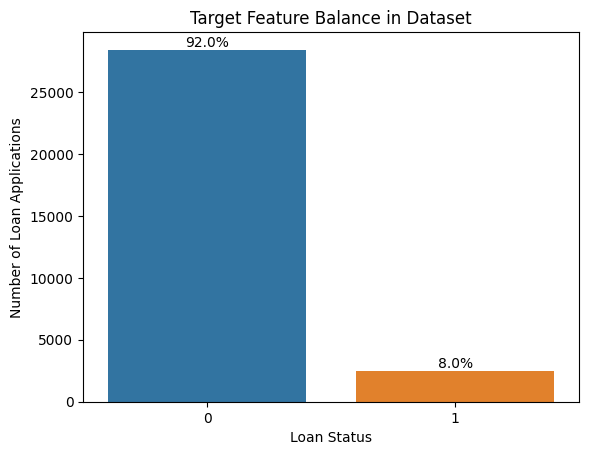

In [9]:
ax = sns.countplot(df, x=df["TARGET"])

ax.set_title("Target Feature Balance in Dataset")

ax.set_xlabel("Loan Status")
ax.set_ylabel("Number of Loan Applications")

for c in ax.containers:
    ax.bar_label(c, fmt=lambda v: f"{(v/len(df))*100:0.1f}%")

All looks good, we can start the feature selection process removing features step by step.

#### Drop duplicates

In [10]:
df.drop_duplicates(inplace=True)

In [11]:
df.shape

(30861, 1247)

For each step of feature drop we can see the reduction in sampled dataframe dimension

#### Drop highly null values

In [12]:
df = ft.selection.remove_highly_null_features(df, pct_null_threshold=0.95)

In [13]:
df.shape

(30861, 1208)

#### Remove single value features

In [14]:
df = ft.selection.remove_single_value_features(df)

In [15]:
df.shape

(30861, 1153)

#### Remove highly correlated features

We have to initialize Featuretools Woodworks to convert dataframe datatypes to Featuretools logic types

In [16]:
df.ww.init()

In [17]:
df = ft.selection.remove_highly_correlated_features(df, pct_corr_threshold=0.95)

In [18]:
df.shape

(30861, 552)

#### Remove non-important feature 

After a few steps we've gone from 1247 features to 554. Now that the big part of the non useful features from the DFS process have been dropped we can apply the feature importance method and get the final set of features to be used for the ML task. Since we are working on a sample of the full dataset I will not split the data and use a very low threshold of importance (1) to retain all features that could possibly be important while training on full dataset.

As mentioned before a default LightGBM model is trained on the sample and feature importance is measured

In [19]:
X = df.drop("TARGET", axis=1)
y = df["TARGET"]

In [20]:
model_features = features.features_above_threshold(X, y, threshold=1)

In [21]:
len(model_features)

372

We can finally check if any of our hard work in deep feature synthesis paid of and if any of the synthetic features sorted by importance appear in at least top 20 

In [22]:
model_features[:21]

['ORGANIZATION_TYPE',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_EMPLOYED',
 'EXT_SOURCE_1',
 'MAX(bureau.DAYS_CREDIT)',
 'DAYS_ID_PUBLISH',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'DAYS_BIRTH',
 'MEAN(bureau.AMT_CREDIT_SUM_DEBT)',
 'REGION_POPULATION_RELATIVE',
 'MAX(bureau.AMT_CREDIT_MAX_OVERDUE)',
 'MAX(bureau.DAYS_CREDIT_ENDDATE)',
 'MIN(bureau.AMT_CREDIT_SUM)',
 'MEAN(prev_app.DAYS_LAST_DUE)',
 'MIN(installment.AMT_PAYMENT)',
 'MAX(bureau.DAYS_ENDDATE_FACT)',
 'DAYS_REGISTRATION',
 'MEAN(bureau.AMT_CREDIT_SUM)',
 'MAX(prev_app.DAYS_LAST_DUE)']

Seems that quite a few aggregated features are of high importance in the model, thats good news. We haven't spent half a day for nothing.

A quick insight into the features, most are generated from credit bureau table and indicate status of applications: time relative to current application, credit limits, credits still due, credit end date relative to the current application.


And finally since we will use the list to import the full dataset lets add our target feature back to the list

In [23]:
model_features.insert(0, "TARGET")

In [24]:
model_features[:5]

['TARGET',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_EMPLOYED']

### Baseline model

We have done the feature engineering, performed feature selection, now its time to establish our baseline and start optimizing for final solution. We will use LightGBM model with and ROC-AUC metric for evaluation, the baseline model will bet fit on "application" table from the dataset only, there will be no engineered features.

In [25]:
scores = pd.DataFrame(
    columns=["Model", "Validation Score", "Test Score", "Number Of Features"]
)

In [26]:
fpr_list = []
tpr_list = []

Improt the application table

In [27]:
df = pd.read_csv("../data/application_train.csv")

In [28]:
df.shape

(307511, 122)

In [29]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Convert object data types to categories for the classifier to handel

In [30]:
df[df.select_dtypes(["object"]).columns] = df.select_dtypes(["object"]).astype(
    "category"
)

Split into train/validation and test partitions 60%/20%/20% respectively.

In [31]:
X = df.drop("TARGET", axis=1)
y = df["TARGET"]

In [32]:
X_train, X_test, X_val, y_train, y_test, y_val = utils.train_test_val_split(
    X, y, train_test_size=0.4, random_seed=RANDOM_SEED
)

We will utilize LightGBM classifier for the baseline model as well as the main models. Choice for LightGBM was made because of the speed and capabilities of natively handling missing values and non-encoded categorical values, this makes the final model easier to deploy.

In [33]:
clf = LGBMClassifier(verbosity=-1, random_state=RANDOM_SEED).fit(X_train, y_train)

In [34]:
y_pred = clf.predict_proba(X_val)[:, 1]
base_val = roc_auc_score(y_val, y_pred)
print(f"Baseline LightGBM model score:{base_val:.3f}")

Baseline LightGBM model score:0.755


ROC-AUC curve

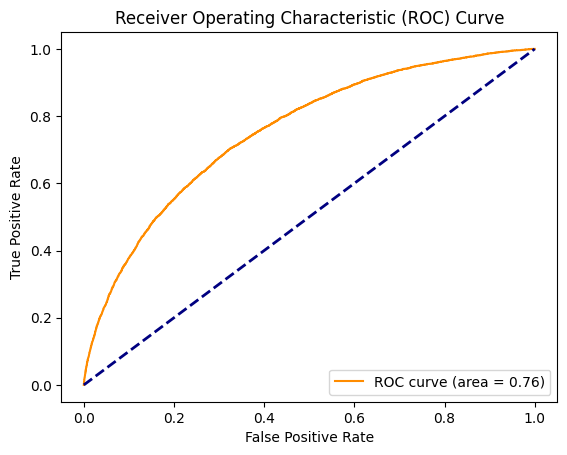

In [35]:
plots.plot_roc(y_val, y_pred)

Store the model scores to results

In [36]:
base_test = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
scores = features.add_scores(
    scores, "Baseline", base_val, base_test, (X_train.shape[1])
)

In [37]:
fpr_base, tpr_base, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
tpr_list.append(tpr_base)
fpr_list.append(fpr_base)

### Main model assembly and tuning

We will now build the final model,with the use bayesian optimization tool Optuna to perform hyperparameter tuning and compare the scores to the baseline model

The model uses all of the features left after feature selection steps. The categorical encoding is done natively by LightGBM, features are not scaled due to the use of tree-based model. 

#### Feature matrix

In [38]:
df = pd.read_csv("../data/engineered_feat.csv", usecols=model_features)
df.shape

(307511, 373)

In [39]:
df.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,...,MODE(pos.prev_app.PRODUCT_COMBINATION),MODE(pos.prev_app.WEEKDAY_APPR_PROCESS_START),NUM_UNIQUE(pos.prev_app.CHANNEL_TYPE),NUM_UNIQUE(pos.prev_app.NAME_CONTRACT_TYPE),NUM_UNIQUE(pos.prev_app.NAME_PAYMENT_TYPE),NUM_UNIQUE(pos.prev_app.NAME_PRODUCT_TYPE),NUM_UNIQUE(pos.prev_app.NAME_YIELD_GROUP),SUM(pos.prev_app.AMT_ANNUITY),SUM(pos.prev_app.NFLAG_INSURED_ON_APPROVAL),SUM(pos.prev_app.RATE_DOWN_PAYMENT)
0,1,Cash loans,M,Y,0,202500.0,406597.5,24700.5,Secondary / secondary special,Single / not married,...,POS other with interest,SATURDAY,1.0,1.0,1.0,1.0,1.0,1.757837e+05,0.0,0.000000
1,0,Cash loans,F,N,0,270000.0,1293502.5,35698.5,Higher education,Married,...,POS household with interest,SATURDAY,3.0,2.0,2.0,2.0,2.0,1.384245e+06,20.0,1.200439
2,0,Revolving loans,M,Y,0,67500.0,135000.0,6750.0,Secondary / secondary special,Single / not married,...,POS mobile without interest,FRIDAY,1.0,1.0,1.0,1.0,1.0,2.142900e+04,0.0,0.848145
3,0,Cash loans,F,Y,0,135000.0,312682.5,29686.5,Secondary / secondary special,Civil marriage,...,POS household with interest,SUNDAY,3.0,2.0,2.0,2.0,3.0,3.828766e+05,0.0,3.049805
4,0,Cash loans,M,Y,0,121500.0,513000.0,21865.5,Secondary / secondary special,Single / not married,...,Cash X-Sell: middle,SUNDAY,3.0,2.0,2.0,3.0,2.0,8.496115e+05,35.0,3.490784


In [40]:
df[df.select_dtypes(["object"]).columns] = df.select_dtypes(["object"]).astype(
    "category"
)

In [41]:
X = df.drop("TARGET", axis=1)
y = df["TARGET"]

In [42]:
X_train, X_test, X_val, y_train, y_test, y_val = utils.train_test_val_split(
    X, y, train_test_size=0.4, random_seed=RANDOM_SEED
)

#### Model optimization

In [43]:
def objective(trial):
    params = {
        "objective": "binary",
        "metric": "auc",
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 31, 128),
        "subsample_for_bin": trial.suggest_int("subsample_for_bin", 10000, 40000),
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000, step=50),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.8, 1.0),
        "subsample": trial.suggest_float("subsample", 0.8, 1.0),
        "max_depth": trial.suggest_int("max_depth", 3, 19),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
    }

    model = LGBMClassifier(**params, verbosity=-1)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, y_pred)

    return roc_auc

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)

With the optimized model parameter grid acquired we can fit the model using them and check the results.

In [46]:
tuned_clf = LGBMClassifier(
    **study.best_params, verbose=-1, random_state=RANDOM_SEED
).fit(X_train, y_train)

In [47]:
y_pred = tuned_clf.predict_proba(X_val)[:, 1]
tuned_val = roc_auc_score(y_val, y_pred)
print(f"Tuned LightGBM model score:{tuned_val:.3f}")

Tuned LightGBM model score:0.781


ROC-AUC curve

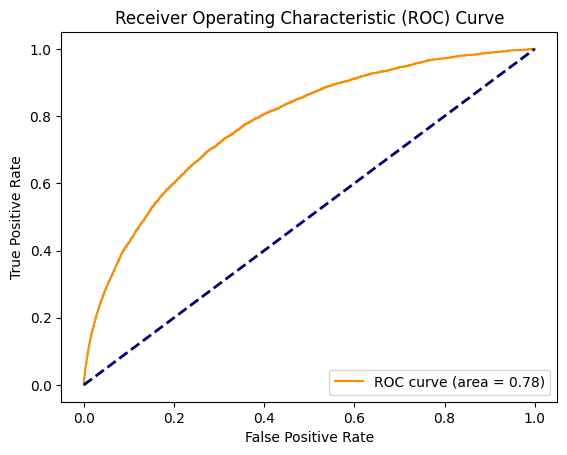

In [48]:
plots.plot_roc(y_val, y_pred)

We will also grab the results from both models for final comparison

In [49]:
tuned_test = roc_auc_score(y_test, tuned_clf.predict_proba(X_test)[:, 1])
scores = features.add_scores(
    scores, "Full Features", tuned_val, tuned_test, X_train.shape[1]
)

In [50]:
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, tuned_clf.predict_proba(X_test)[:, 1])
tpr_list.append(tpr_tuned)
fpr_list.append(fpr_tuned)

#### Model explainability 

To inspect how the model made the predictions we will use SHAP and plot feature impact on the prediction

In [51]:
shap.initjs()

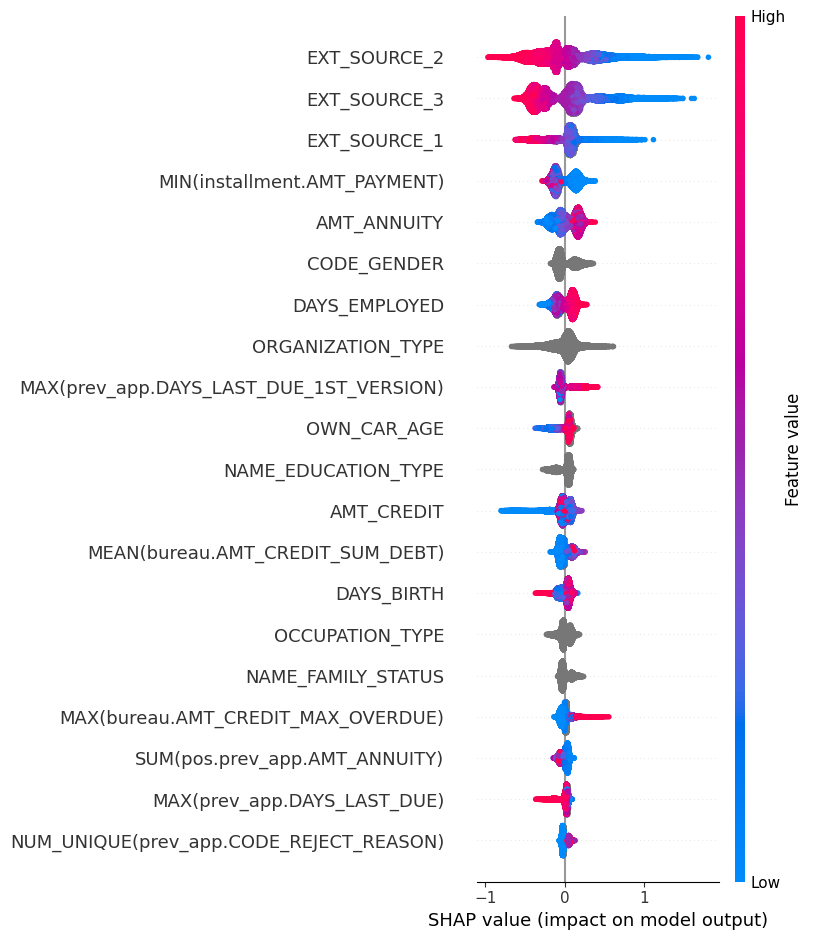

In [52]:
explainer = shap.TreeExplainer(tuned_clf)

shap_values = explainer.shap_values(X_val)


shap.summary_plot(shap_values[1], X_val, feature_names=X_train.columns)

EXTERNAL SOURCE features that were identified as most significant in our hypothesis testing and rated as most important by the model are the top 3 features in predicting loan default target. Interestingly amount of annuity, gender and organization type also seem to have moderate impact on model prediction. The rest of the features have significantly lower impact and are less important for the model while making predictions.


We can also have a look at individual plots for highest prediction probability correct and lowest prediction probability incorrect predictions. This might give us an insight which features contribute the most to correct and incorrect model predictions and where the model is making mistakes.

In [53]:
(
    shap_values_correct,
    shap_values_incorrect,
    prob_correct,
    prob_incorrect,
) = utils.shap_force_feats(tuned_clf, X_val, y_val)

In [54]:
shap.force_plot(
    explainer.expected_value[1], shap_values_correct[1], X_val.iloc[prob_correct, :]
)

In [55]:
shap.force_plot(
    explainer.expected_value[1], shap_values_incorrect[1], X_val.iloc[prob_incorrect, :]
)

### Simplified models

We will also assemble a few simplified models with only the top 10 features by importance applied to evaluate how dropping the bulk of the information will impact the model performance.

Two simplified models will be assembled:
- Model 1: Top 10 features including aggregated historical data
- Model 2: Top 10 features only from application table features

When the feature importance was calculated the resulting list of important features was sorted in a descending fashion, we will take top 10 features only and train another model to compare the complexity and resulting score trade-off

#### Model 1

We will split of the top feature into a new dataframe for model training

In [56]:
df_simplified = df[model_features[:11]]

In [57]:
X = df_simplified.drop(["TARGET"], axis=1)
y = df_simplified["TARGET"]

In [58]:
X_train, X_test, X_val, y_train, y_test, y_val = utils.train_test_val_split(
    X, y, train_test_size=0.4, random_seed=RANDOM_SEED
)

We will tune the hyperparameters for the simplified model reusing the objective function for Optuna

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

In [61]:
simple_clf = LGBMClassifier(
    **study.best_params, verbosity=-1, random_state=RANDOM_SEED
).fit(X_train, y_train)

In [62]:
y_pred = simple_clf.predict_proba(X_val)[:, 1]
simple_val = roc_auc_score(y_val, y_pred)
print(f"Tuned SimpleLGBM model score:{simple_val:.3f}")

Tuned SimpleLGBM model score:0.746


ROC-AUC curve

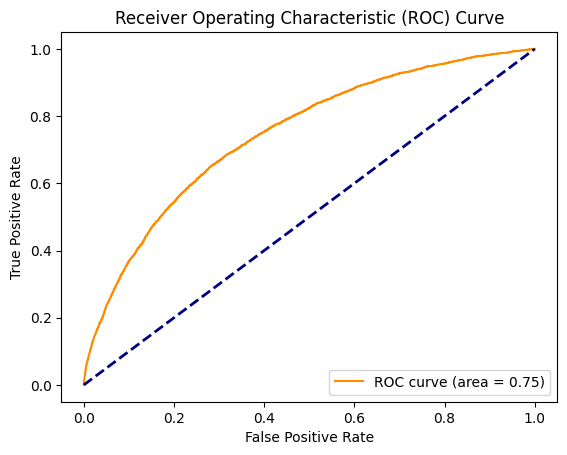

In [63]:
plots.plot_roc(y_val, y_pred)

Store the model scores to results

In [64]:
simple_test = roc_auc_score(y_test, simple_clf.predict_proba(X_test)[:, 1])
scores = features.add_scores(
    scores, "Simplified Model 1", simple_val, simple_test, X_train.shape[1]
)

In [65]:
fpr_simple1, tpr_simple1, _ = roc_curve(y_test, simple_clf.predict_proba(X_test)[:, 1])
tpr_list.append(tpr_simple1)
fpr_list.append(fpr_simple1)

#### Model 2

For the second simplified model we will take the top 10 features by importance from feature selection part and exclude any features that came from external tables, leaving only information available in application table.

In [66]:
df_simplified = df[
    [
        "TARGET",
        "ORGANIZATION_TYPE",
        "EXT_SOURCE_2",
        "EXT_SOURCE_1",
        "EXT_SOURCE_3",
        "DAYS_EMPLOYED",
        "DAYS_REGISTRATION",
        "AMT_ANNUITY",
        "AMT_CREDIT",
        "DAYS_ID_PUBLISH",
        "DAYS_LAST_PHONE_CHANGE",
    ]
]

In [67]:
X = df_simplified.drop(["TARGET"], axis=1)
y = df_simplified["TARGET"]

In [68]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=RANDOM_SEED
)
X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=RANDOM_SEED
)

Hyperparameter optimzation using Optuna

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

In [71]:
simple2_clf = LGBMClassifier(
    **study.best_params, verbosity=-1, random_state=RANDOM_SEED
).fit(X_train, y_train)

In [72]:
y_pred = simple2_clf.predict_proba(X_val)[:, 1]
simple2_val = roc_auc_score(y_val, y_pred)

In [73]:
print(f"Tuned SimpleLGBM model score:{simple2_val:.3f}")

Tuned SimpleLGBM model score:0.744


And the ROC-AUC curve

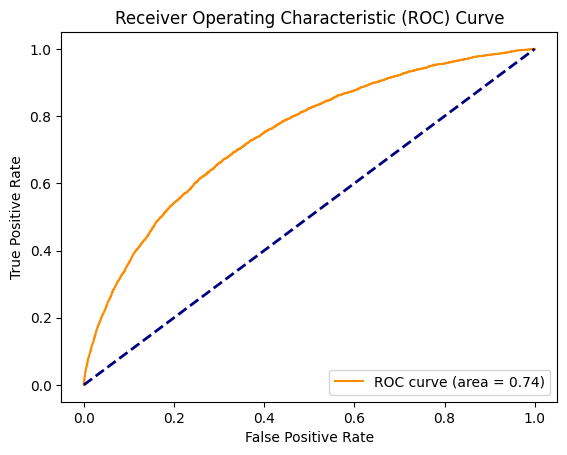

In [74]:
plots.plot_roc(y_val, y_pred)

Store the model scores to results

In [75]:
simple2_test = roc_auc_score(y_test, simple2_clf.predict_proba(X_test)[:, 1])
scores = features.add_scores(
    scores, "Simplified Model 2", simple2_val, simple2_test, X_train.shape[1]
)

In [76]:
fpr_simple2, tpr_simple2, _ = roc_curve(y_test, simple_clf.predict_proba(X_test)[:, 1])
tpr_list.append(tpr_simple2)
fpr_list.append(fpr_simple2)

#### Model explainability

To better understand how a more simplified models make the predictions we turn to SHAP again. 
Lets have a look at Model 1 first

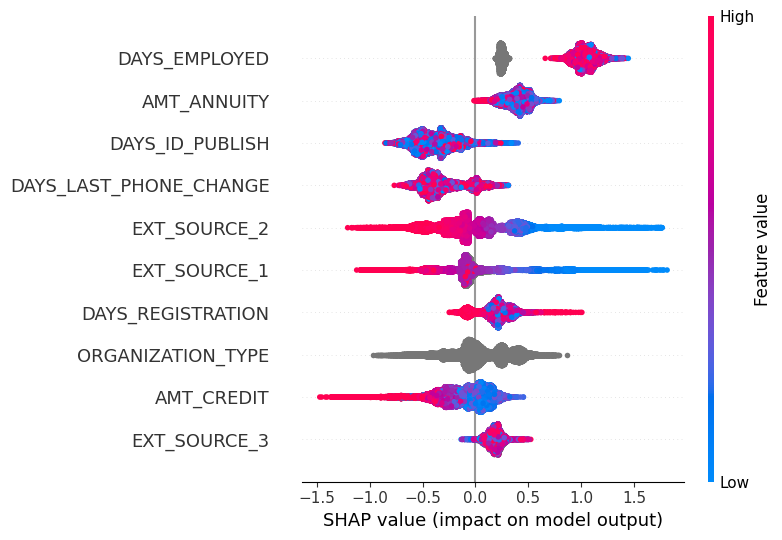

In [77]:
explainer = shap.TreeExplainer(simple_clf)

shap_values = explainer.shap_values(X_val)

shap.summary_plot(shap_values[1], X_val, feature_names=X_train.columns)

External_Source features are at the top with the highest impact on the model, we can also see that there are only three features not from application table, explaining why both simplified models achieve  the same performance- they share majority of the features and the signal difference between the historical aggregated features and application table features is most likely very minimal.

We can also have a look at individual predictions for highest prediction probability and lowest prediction probability scores.

In [78]:
(
    shap_values_correct,
    shap_values_incorrect,
    prob_correct,
    prob_incorrect,
) = utils.shap_force_feats(simple_clf, X_val, y_val)

Shap single correct model prediction force plot with the highgest probability

In [79]:
shap.force_plot(
    explainer.expected_value[1], shap_values_correct[1], X_val.iloc[prob_correct, :]
)

SHAP single incorrect model prediction with lowest probability

In [80]:
shap.force_plot(
    explainer.expected_value[1], shap_values_incorrect[1], X_val.iloc[prob_incorrect, :]
)

Looks like the dominant three EXT_SOURCE features are responsible for the majority of the impact on model prediction in both cases. Interestingly DAYS_LAST_PHONE_CHANGE, which is a feature describing how long before the application the customer has changed their phone number on the platform is a huge contributor to incorrect prediction. More in depth analysis might reveal why the feature is has such a high impact.

### Model Comparison

Finally we can look at the scores of all of the models we tried out

As a reminder ROC-AUC is the metric of choice for the inbalanced classification problem. We care for both Type I and Type II errors, as predicting a false positive (Type I) error would result in loan not being issued due to to risk of default and potential profit not realized. Meanwhile false negatives (Type II) error would result in the loan being issued while the probability of the loan defaulting being high, the potential loss would result in whole or part-off the credit amount.

In [87]:
scores.sort_values(by=["Validation Score"], ascending=False)

,Model,Validation Score,Test Score,Number Of Features
1,Full Features,0.781324,0.779725,372
0,Baseline,0.755152,0.755984,121
2,Simplified Model 1,0.746173,0.747567,10
3,Simplified Model 2,0.743514,0.743111,10


We can see improvements on the tuned model with full set of useful features determined in the feature selection process. With the total of 375 application and aggregated historical bureau/previous application features the model achieved a slightly better ROC-AUC score. While the simplified models achieved considerably lower scores, simplified model 2 with only top 10 features from application table also performed considerably worse.


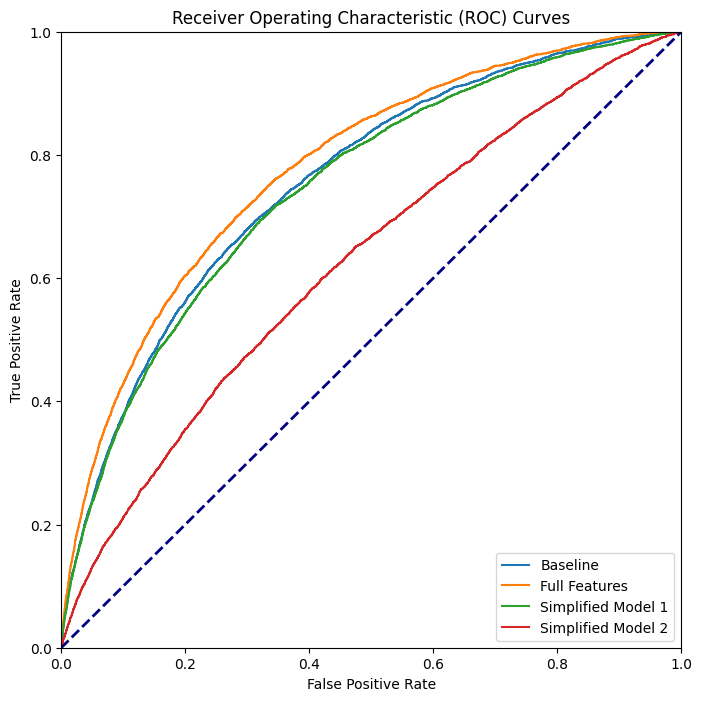

In [82]:
plots.multi_roc_curves(scores["Model"].values.tolist(), fpr_list, tpr_list)

ROC-AUC plot for all models show how each model performs across all thresholds. The shape is smooth and almost identical for all models, with the only difference being offset from the dashed no-skill diagonal line.

It is also visible where the full engineered feature tuned model is outperforming the Baseline model across the thresholds.

### Save the models

We will deploy the simplistic model on Google Cloud Platform for demonstration purposes, for that we need a small pipeline to handle categorical features being posted in request.

In [83]:
preprocessor = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(), ["ORGANIZATION_TYPE"])]
)

In [84]:
pipe = Pipeline([("preprocessor", preprocessor), ("classifier", simple2_clf)])

In [85]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['ORGANIZATION_TYPE'])])),
                ('classifier',
                 LGBMClassifier(colsample_bytree=0.8237422836350925,
                                learning_rate=0.071114600078936, max_depth=3,
                                n_estimators=600, num_leaves=64,
                                random_state=42, reg_alpha=0.830463916381488,
                                reg_lambda=0.712914310103004,
                                subsample=0.9245810205043492,
                                subsample_for_bin=21254, verbosity=-1))])

In [86]:
output = "../app/simple_model.sav"
joblib.dump(pipe, output)

['../app/simple_model.sav']

## Conclusions

Feature selection,modelling and model evaluation were performed on the dataframe generated in Feature_engineering.ipynb with deep feature synthesis.Following methods were used to select the features for the model:

- Removal of highly null features (>95% threshold)
- Removal of single value(low variance) features
- Removal of highly correlated features (>95% threshold)
- Removal of features with feature importance <1 from the baseline LightGBM model

ROC-AUC metric was chosen for model evaluation.

Baseline LightGBM model was fit on the application table data. A model with full engineered feature matrix was tuned using Optuna for maximized AUC metric.

Two simplified models were generated and tuned using Optuna for maximized AUC metric:

- Model 1 - LightGBM classifier with top 10 features by importance including aggregated historical data
- Model 2 - LightGBM classifier with top 10 features by importance only from application table

Select models analyzed using SHAP for feature impact on predictions and worst/best single predictions analyzed for feature impact.

### Results

EXTERNAL SOURCE (1,2,3) features are the most impactful for every model.

Models compared by score with the following results (best to worst):

1. Tuned model with full engineered feature set
2. Baseline model with full application table feature set
3. Simplified Model 1
4. Simplified Model 2

One of the simplified models was fit to a pipeline and saved to be deployed as a demo on GCP.


## Possible improvements

- Model could be integrated into a full pipeline including deep feature synthesis
- Full model features could be further reduced for an acceptable drop in model performance simplifying model
- Model threshold should be tuned with domain knowledge and business profit/loss available
- More in depth analysis on features contributing to wrong model predictions should be carried out
- Final model could be stacked to an ensemble for even better performance at a cost of a more complex model